In [1]:
from astropy.timeseries import BoxLeastSquares
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import scipy
import glob
import os
import pandas as pd
import lightkurve as lk
import csv
import time
from astropy.table import Table



# Useful Functions

In [2]:
### opens from CLEANED lightcurves----FAST
def open_lc(tic,path):
    '''
    Opens lightkurvefile object as a lightkurve file...
    ...a work around b/c cleaned_lcs saved as lkfiles lose the flux attribute
    
    Requirements: astropy.io.fits; lightkurve;
    inputs:   tic (int or str)
              path (str); '"mypath" is for me only, all others must specify filepath'
    outputs:  lightkurve lightcurve object
              additional output - writes text file of tics unable to open & exceptions (this path is hardcoded so only works for me)
    '''
    try:
        if path == 'mypath':
            filepath = 'data/SECONDRUN/cleaned_LightCurves/{}/lc.fits'.format(tic)
        else:
            filepath = path
        openfile = fits.open(filepath)
        filedata = openfile[1].data
        lc = lk.lightcurve.TessLightCurve(flux=filedata['FLUX'],time=filedata['TIME'],flux_err=filedata['FLUX_ERR'])
    except Exception as e:
        lc = -99
        print('TIC: {} failed to open as lk lc'.format(tic))
        stmt = 'TIC: {} had error {}\n'.format(tic,e)
#         with open("data/FOURTHRUN/BLS_couldnt_openfile.txt","a") as text_file:
#             text_file.write("\n")
#             text_file.write(stmt)
    return lc

In [282]:
## BLS code & data prep

# opens from RAW data and cleans---SLOW
def prep_lcfs(tic,path=None):
	""" 
	Locates all TESS lightcurve files with filenames formatted from a mast bulk dl.
	Does minor cleaning & stitching, then plots final lightcurve.
    
	REQUIRES: lightkurve, glob, os


    
	Args:
		tic: TIC identification number (integer or string).
		path: (optional) computer path to file location (string) (excluding filename).
        
	Returns:
		cleaned & stitched lightkurve object.
	"""
#locates files
	if path == None: #if only need filename
		fullpath = glob.glob('*{}-*-s_lc.fits'.format(tic)) #to use wildcard*
	elif path == 'mypath': #path on my computer
		fullpath = glob.glob('/Volumes/Seagate-stars/LightCurves/*{}-*-s_lc.fits'.format(tic))#to use wildcard*
        #cant use b/c wont retain lk fcns:::::fits.open('data/SECONDRUN/cleaned_LightCurves/{}/lc.fits'.format(tic)) 
	else: #to change path for other computer
		pathstart = path #user defined path to datafile on their computer  
		pathstart = str(pathstart) #make a string in case user forgets to but think that gives an err anyway
		pathend = pathstart +'*{}-*-s_lc.fits'.format(tic) #stitches path & filename
		fullpath= glob.glob(pathend) #to use wildcard* 
#collects files into a lightkurve class object
	lcfs =[] 
	sectorspresent = []
	idx = [] #goods
	idxs = [] #bads
	mylist = [1,2,3,4,5,6,7,8,9,10,11,12,13]
	for i in mylist:
		try:
			for file in fullpath:
				#print(file)
				lcfile = lk.open(file) #open only works one file at a time
				mystring = str(type(lcfile))
				if mystring[34:-2] == 'TessLightCurveFile': #guards against'TessTargetPixelFile'& more
					hdr = lcfile.header()
					sector = hdr['SECTOR']
					if i == sector:
						lcfs.append(lcfile) #collect
						sectorspresent.append(sector)
						idx.append(i)
						badtic = [0, idx]
					else:
						pass
				else:
					pass
		except ValueError:
			idxs.append(i)
			badtic = [tic, idxs]
	if len(lcfs)==0: 
		print('Unable to locate any files for TIC {}; verify path/files exist'.format(tic))
		cleaned = -99
		number_ofsectors=0 #use to match with tic list and remove tics with no info
		usedsectors = 0
		badtic=-99
	else:
		number_ofsectors = int(len(lcfs))
		usedsectors = sectorspresent #0
#cleans & stitches #& plots
		lcfiles = lk.collections.LightCurveFileCollection(lcfs) #making list into class collection
		stitched = lcfiles.PDCSAP_FLUX.stitch() #this detrends/normalizes each sector before stitching together all lightcurves
		#could mask bad bits here then stitch, instead of stitch above
		nonans = stitched.remove_nans() #preps for periodogram etc
		cleaned = nonans #.remove_outliers(sigma=6) #removes cosmic rays & flares mostly
		badtic=-99
        
	return cleaned, badtic #target final data table containing flux, time, flux_err 




def run_bls(tic,lc,plot=False):
	'''
	Runs BoxLeastSquares(BLS) on a light curve and returns BLS statistics.
    
	REQUIRES: numpy, astropy.timeseries.BoxLeastSquares,
	Args:   tic id      -(int or str)
            lc          -(lightkurve light curve object)
            plot        -(boolean) optional, if True plots 
                          periodogram and phase folded light curve 
                          and binned phase folded light curve
                    
	outputs: bls_stats  -(dictionary) Box Least Squares statistics 
                          of 'power', 'period', 'depth', 'duration', 'transit_time' 
    '''
# 	assert(str(type(lc)) == "<class 'lightkurve.lightcurve.TessLightCurve'>");
	###gets cleaned data
	clean = lc.flatten()
# 	clean = clean.remove_outliers(sigma=7)
	time = clean.time - clean.time[0]
	flux = clean.flux
	fluxerr = clean.flux_err
	###gets periodogram based on bls
	from astropy.timeseries import BoxLeastSquares
	model = BoxLeastSquares(time, flux, dy=fluxerr) #dy=0.01)
	period_grid = np.linspace(.5,20,5000)#np.linspace(.1, 20, 50000) #1.0, 20, 50000should this stay the same?
# 	period_grid = np.logspace(.5,20,5000) #logspace causes some internal bls error
	duration_grid = np.linspace(.01,.49,3)#1000)#(.01,.49,1000)
	periodogram = model.power(period_grid, duration_grid) 
	ppower = np.argmax(periodogram.power)
	pperiod = periodogram.period[np.argmax(periodogram.power)]
	depth = periodogram.depth[np.argmax(periodogram.power)]
	duration = periodogram.duration[np.argmax(periodogram.power)]
	tt = periodogram.transit_time[np.argmax(periodogram.power)]
	bls_stats={}
	bls_stats['power']=ppower
	bls_stats['period']=pperiod
	bls_stats['depth']=depth
	bls_stats['duration']=duration
	bls_stats['transit_time']=tt
	bls_stats['periodogram']=periodogram
	###do some phase folding
	fold = clean.fold(period=periodogram.period[np.argmax(periodogram.power)])
	binfold = fold.bin(binsize=50)
	if plot == True:
		plt.clf()
		plt.plot(fold.time,fold.flux, '.',label = 'folded data')
		plt.plot(binfold.time,binfold.flux, 'r',lw=2, label = 'binned fold')
		plt.xlabel('Phase',fontsize=20)
		plt.ylabel('Relative Flux',fontsize=20)
		plt.title('All Sectors for TIC: {}'.format(tic),fontsize=20)
		fig=plt.gcf()
		fig.set_size_inches(20,14)
		plt.close()
		plt.clf()
		plt.plot(periodogram.period, periodogram.power) 
		plt.title('Periodogram for TIC: {}'.format(tic),fontsize=20)
		plt.xlabel('period',fontsize=20)
		plt.ylabel('power',fontsize=20)
		fig=plt.gcf()#gets current figure or creates one if none
		fig.set_size_inches(20,14)
		plt.show() 
	else:
		pass
    
	return bls_stats #power, period, depth, transit_time, duration,periodogram


In [4]:
##generate simulated lightcurves

def sim_lc(plot=False,noise = False,t = np.linspace(0,27,19440), 
           per= 1., rp=0.1, t0 = 1.,a = 15., inc=87., ecc = 0., 
           w=90., limb_dark ='nonlinear',u = [0.5, 0.1, 0.1, -0.1]):
    
    """
    Simulates a one-sector long TESS light curve with injected planet transits per input parameters.
    
    Args:     plot       =boolean; if True plots simulated light curve, default=False doesn't show plot;
              noise      =boolean; if True injects .0005 noise into flux, default=False is noise free;
              t          =times at which to calculate light curve, default is one TESS sector;
              per        =orbital period;
              rp         =planet radius (in units of stellar radii);
              t0         =time of inferior conjunction);
              a          =semi-major axis (in units of stellar radii);
              inc        =orbital inclination (in degrees);
              ecc        =eccentricity;
              w          =longitude of periastron (in degrees);
              limb_dark  =limb darkening model;
              u          =limb darkening coefficients [u1, u2, u3, u4];
    
    outputs: lc OR lc_noise    =lightkurve TESS light curve object with
                                planet transits for one sector (27 days);
                                lc has no injected noise, lc_noise has 
                                injected noise;
    
    """
    
    import batman
    params = batman.TransitParams()       
    params.t0 = t0                        
    params.per = per                       
    params.rp = rp                       
    params.a = a                        
    params.inc = inc                      
    params.ecc = ecc                       
    params.w = w                        
    params.limb_dark = limb_dark        
    params.u = u      

    m = batman.TransitModel(params, t)    #initializes model
    flux = m.light_curve(params)        #calculates light curve
    if noise == True:
        unc_level=.001
        flux_wnoise = np.random.randn(len(flux))*unc_level + flux
        noise = np.ones_like(flux)*unc_level
        #make it a lk object for phase-folding plots below
        lc_noise = lk.lightcurve.TessLightCurve(flux=flux_wnoise,time=t,flux_err=noise)
        if plot==True:
            lc_noise.plot()
            plt.title('WITH injected noise')
        return lc_noise
    else:
        #make it a lk object for phase-folding plots below
        low_err = np.repeat(0.0001,len(flux))
        lc = lk.lightcurve.TessLightCurve(flux=flux,time=t,flux_err=low_err)
        if plot==True:
            lc.plot()
            plt.title('Please use noise=True; this lc is w/o injected noise')
        return lc

# Test example ~ Real ~ lcs

In [5]:
# load data

planet_tics = [149603524,141622065,260271203,278956474,349518145,373844472,55524055] #some of these are confirmed/some might be EBs
eb_tics = [348897766,309659126,30631330,260654645]# definitely EBs
astro_tics = [25117741,25063986,25116563,55451820,260709448,30314282,30319402,140801898]
flat_tics = [55650481,55499190,25133068,25133604,25133636,25133966,25134567,25153041]  
idk_tics = [30468581,30315127,30630877,30631031,31013214]
# mylists = [planet_tics,eb_tics,astro_tics,flat_tics,idk_tics] #a list of lists
print('planets:',len(planet_tics),'ebs:',len(eb_tics),'astro:',len(astro_tics),'flats:',len(flat_tics),'idk:',len(idk_tics))
mylists2 = planet_tics+eb_tics+astro_tics+flat_tics+idk_tics #appends lists to one list
print('total examples:',len(mylists2))

planets: 7 ebs: 4 astro: 8 flats: 8 idk: 5
total examples: 32


In [6]:
# get BLS stats off real lcs

real_stats={}
for count,tic in enumerate(mylists2):
#     print(count,tic)
#     lc, badlc = prep_lcfs(tic,'mypath') #cleans from raw---SLOW
    lc = open_lc(tic,'mypath') #opens cleaned lcs---FAST
    if lc != -99:
        real_stats[str(tic)] = run_bls(str(tic),lc)
    else:
        print('no clean lc for TIC {}'.format(tic))
        continue

0 149603524
1 141622065
2 260271203
3 278956474
4 349518145
5 373844472
6 55524055
7 348897766
8 309659126
9 30631330
10 260654645
11 25117741
12 25063986
13 25116563
14 55451820
15 260709448
16 30314282
17 30319402
18 140801898
19 55650481
20 55499190
21 25133068
22 25133604
23 25133636
24 25133966
25 25134567
26 25153041
27 30468581
28 30315127
29 30630877
30 30631031
31 31013214


In [78]:
astro = {}; ebs={}; planets={};idk={};flats={}
apower=[];adepth=[];adur=[];aper=[];att=[];atic=[]
epower=[];edepth=[];edur=[];eper=[];ett=[];etic=[]
ppower=[];pdepth=[];pdur=[];pper=[];ptt=[];ptic=[];
ipower=[];idepth=[];idur=[];iper=[];itt=[];itic=[];
fpower=[];fdepth=[];fdur=[];fper=[];ftt=[];ftic=[];
for key in list(real_stats.keys()):
    if int(key) in astro_tics:
        real_stats[key]['type'] = 'astro'
        apower.append(real_stats[key]['power']);astro['powers'] = apower
        adepth.append(real_stats[key]['depth']);astro['depths']= adepth
        adur.append(real_stats[key]['duration']);astro['durations']=adur
        aper.append(real_stats[key]['period']);astro['periods']=aper
        att.append(real_stats[key]['transit_time']);astro['transit_times']=att
        atic.append(key);astro['tic']=atic
#         astro['tic']=atic
    elif int(key) in planet_tics: 
        real_stats[key]['type'] = 'planet'
        ppower.append(real_stats[key]['power'])
        planets['powers'] = ppower
        pdepth.append(real_stats[key]['depth'])
        planets['depths']= pdepth
        pdur.append(real_stats[key]['duration'])
        planets['durations']=pdur
        pper.append(real_stats[key]['period'])
        planets['periods']=pper
        ptt.append(real_stats[key]['transit_time'])
        planets['transit_times']=ptt
        ptic.append(key)
        planets['tic']=ptic
    elif int(key) in eb_tics:
        real_stats[key]['type'] = 'eb'
        epower.append(real_stats[key]['power'])
        ebs['powers'] = epower
        edepth.append(real_stats[key]['depth'])
        ebs['depths']= edepth
        edur.append(real_stats[key]['duration'])
        ebs['durations']=edur
        eper.append(real_stats[key]['period'])
        ebs['periods']=eper
        ett.append(real_stats[key]['transit_time'])
        ebs['transit_times']=ett
        etic.append(key)
        ebs['tic']=etic
    elif int(key) in flat_tics: 
        real_stats[key]['type'] = 'flat'
        fpower.append(real_stats[key]['power'])
        flats['powers'] = fpower
        fdepth.append(real_stats[key]['depth'])
        flats['depths']= fdepth
        fdur.append(real_stats[key]['duration'])
        flats['durations']=fdur
        fper.append(real_stats[key]['period'])
        flats['periods']=fper
        ftt.append(real_stats[key]['transit_time'])
        flats['transit_times']=ftt
        ftic.append(key)
        flats['tic']=ftic
    elif int(key) in idk_tics: 
        real_stats[key]['type'] = 'idk'
        ipower.append(real_stats[key]['power'])
        idk['powers'] = ipower
        idepth.append(real_stats[key]['depth'])
        idk['depths']= idepth
        idur.append(real_stats[key]['duration'])
        idk['durations']=idur
        iper.append(real_stats[key]['period'])
        idk['periods']=iper
        itt.append(real_stats[key]['transit_time'])
        idk['transit_times']=itt
        itic.append(key)
        idk['tic']=itic
    else:
        print(key,'had errors')

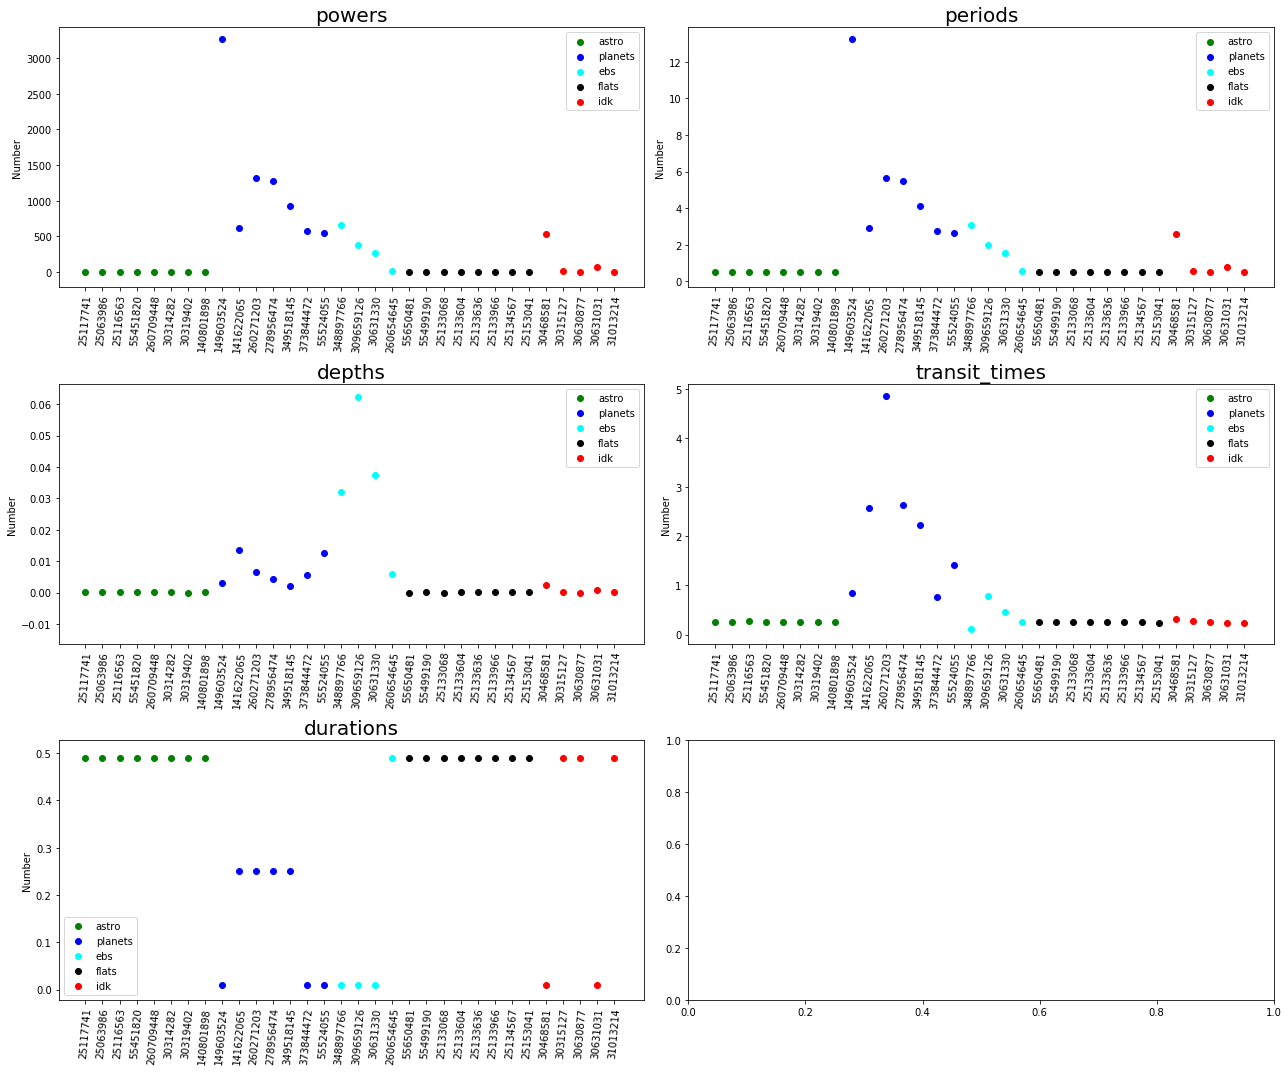

In [79]:
# look at stats from real lcs

f, (axes) = plt.subplots(3,2,figsize=(18,15))
for i in range(5):
    if i == 0:
        x,y,param = 0,0,'powers'
    elif i == 1:
        x,y,param = 0,1,'periods'
    elif i == 2:
        x,y,param = 1,0,'depths'
    elif i == 3:
        x,y,param = 1,1,'transit_times'
    elif i == 4:
        x,y,param = 2,0,'durations'
    axes[x,y].scatter(list(astro['tic']),list(astro[param]),color='g',label='astro')
    axes[x,y].scatter(list(planets['tic']),list(planets[param]),color='b',label='planets')
    axes[x,y].scatter(list(ebs['tic']),list(ebs[param]),color='cyan',label='ebs')
    axes[x,y].scatter(list(flats['tic']),list(flats[param]),color='k',label='flats')
    axes[x,y].scatter(list(idk['tic']),list(idk[param]),color='r',label='idk')
    axes[x,y].legend()
    axes[x,y].set_ylabel('Number')
    axes[x,y].set_title('{}'.format(param),fontsize=20)
    for tick in axes[x,y].get_xticklabels():
        tick.set_rotation(85)
plt.tight_layout()

In [257]:
group_stat_names = ['powers', 'periods', 'depths', 'transit_times', 'durations']
groups = [astro,ebs,planets,idk,flats];group_names=['astro','ebs','planets','idk','flats']
for count,param in enumerate(group_stat_names):
    stat = list(groups[count][param])
    print('{}:'.format(group_names[count]), min(stat),'--',max(stat))

astro: 0 -- 7
ebs: 0.5468093618723745 -- 3.094018803760752
planets: 0.001954192580662815 -- 0.01354404776633799
idk: 0.228 -- 0.31
flats: 0.49 -- 0.49


In [227]:
powers=[];durations=[];tts=[];periods=[];depths=[]
for i in list(real_stats.keys()):
    power=real_stats[i]['power'];per=real_stats[i]['period'];dur=real_stats[i]['duration']
    tt=real_stats[i]['transit_time'];dep=real_stats[i]['depth']
    powers.append(power);durations.append(dur);tts.append(tt);periods.append(per);depths.append(dep)
print(len(powers),len(durations),len(tts),len(periods),len(depths))

arrs = [powers,periods,depths,tts,durations]
stat_names = ['power', 'period', 'depth', 'transit_time', 'duration']
for count,arr in enumerate(arrs):
    lo = min(arr)
    hi = max(arr)
    print('{}: '.format(stat_names[count]),lo,'--',hi)

32 32 32 32 32
power:  0 -- 3265
period:  0.5 -- 13.236047209441889
depth:  5.917551289759998e-06 -- 0.062352512203618954
transit_time:  0.12000000000000001 -- 4.862
duration:  0.01 -- 0.49


0 : 149603524
1 : 141622065
2 : 260271203
3 : 278956474
4 : 349518145
5 : 373844472
6 : 55524055
7 : 348897766
8 : 309659126
9 : 30631330
10 : 260654645
11 : 25117741
12 : 25063986
13 : 25116563
14 : 55451820
15 : 260709448
16 : 30314282
17 : 30319402
18 : 140801898
19 : 55650481
20 : 55499190
21 : 25133068
22 : 25133604
23 : 25133636
24 : 25133966
25 : 25134567
26 : 25153041
27 : 30468581
28 : 30315127
29 : 30630877
30 : 30631031
31 : 31013214


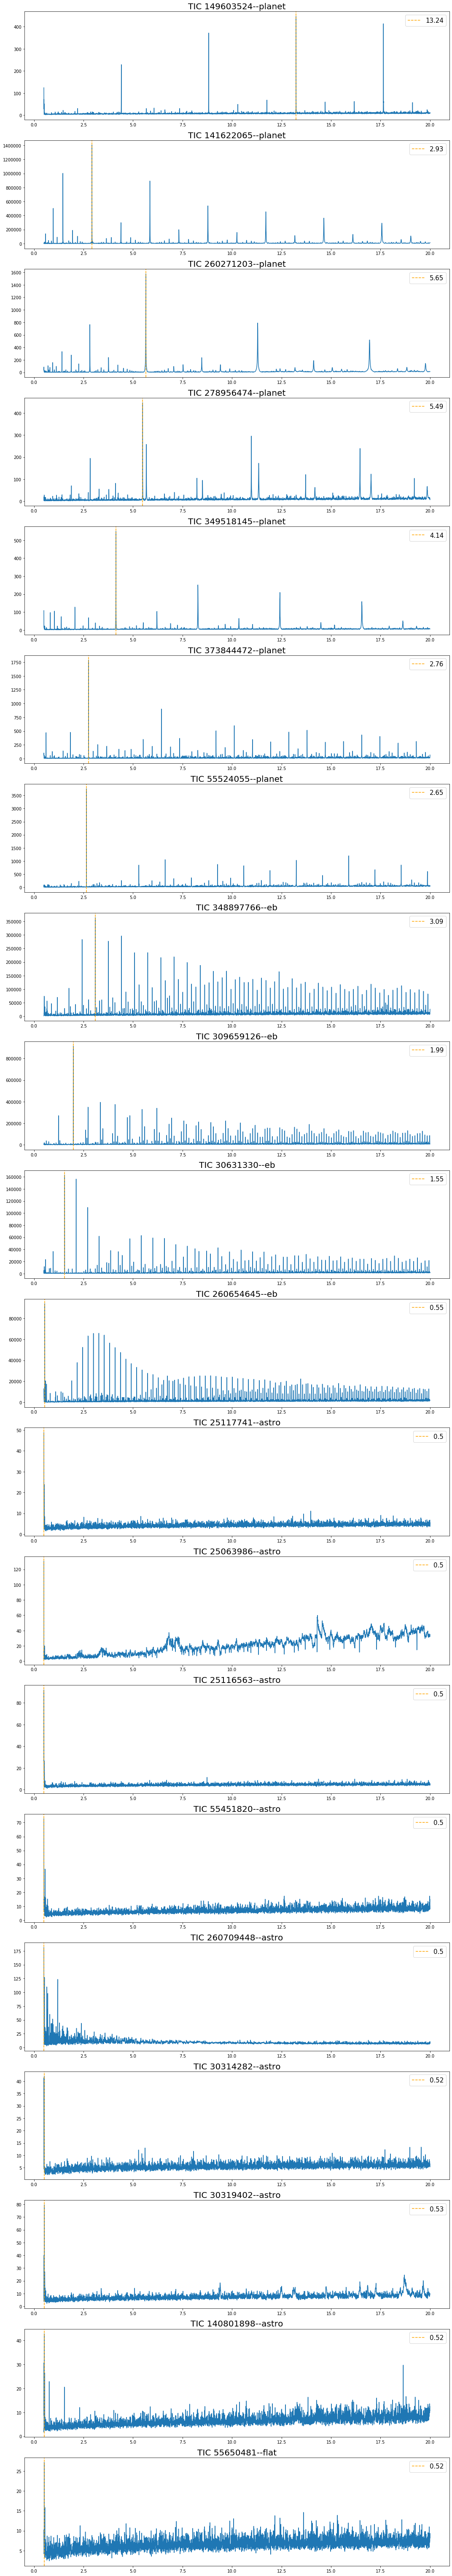

In [10]:
###check bls periodograms for real lcs

f, ax = plt.subplots(20,1,figsize=(15,85))
for count,i in enumerate(list(real_stats.keys())):
    print(count,':',i)
    if count < 20:
        ax[count].plot(real_stats[i]['periodogram'].period,real_stats[i]['periodogram'].power)
        ax[count].axvline(real_stats[i]['period'],color='orange',ls='--',label=round(real_stats[i]['period'],2))
        ax[count].set_title('TIC {}--{}'.format(i,real_stats[i]['type']),fontsize=20)
        ax[count].legend(fontsize=15)
    else:
        pass
plt.tight_layout()

# Test ~ Simulated ~ lcs

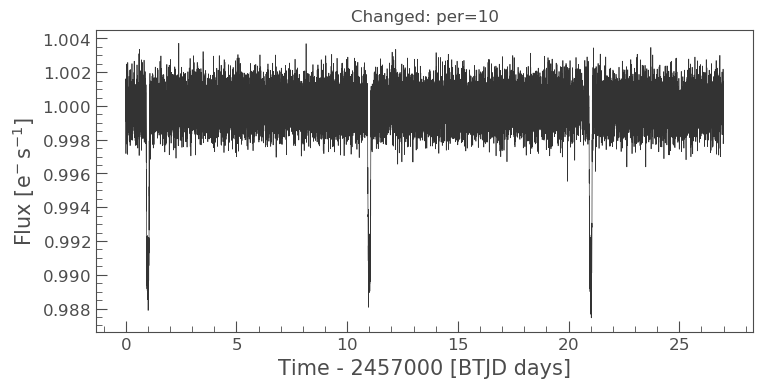

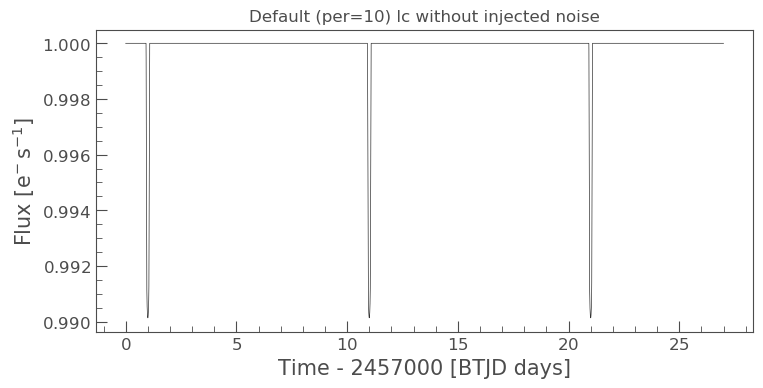

In [11]:
## test one sim_lc

#create & plot sim_lc
test_value = 10
test_sim_lc1 = sim_lc(plot=True,per=test_value,noise=True) 
plt.title('Using Sim_LC with: per={}'.format(test_value))
test_sim_lc2 = sim_lc(plot=True,per=test_value)
plt.title('Default (per=10) lc without injected noise');

# run bls on simulated_lc above
sim_stats_test = run_bls('test_sim_lc1',test_sim_lc1)
print('expected period at {} and got:'.format(test_value),sim_stats_test['period'])#expected 10

## lessons learned:
# dont use rp>3 will block out all stellar light...ie get a flat signal; 3 makes big/wide box, lower makes narrower dip
# per changes the flux and width of dips: this is a confusing param
# a makes width of transit more narrow (higher a) or wider (lower a)

expected period at 10 and got: 10.002300460092018


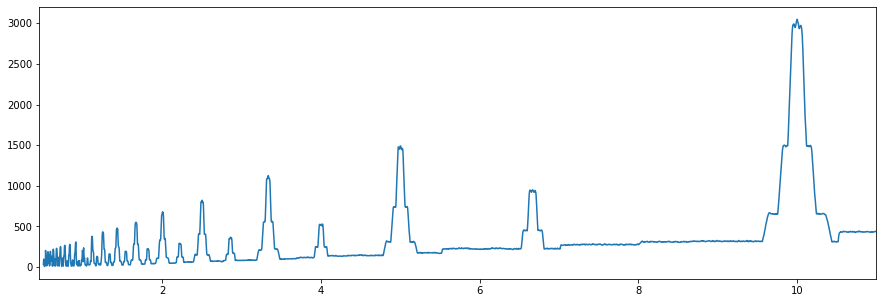

In [13]:
#plotting periodogram for above sim_lc per=10
plt.figure(figsize=(15,5))
plt.plot(sim_stats_test['periodogram'].period,sim_stats_test['periodogram'].power)
plt.axvline(sim_stats_test['period'],ls='--',color='orange',label=sim_stats_test['period'])
plt.legend(fontsize=20)
plt.xlabel('Power',fontsize=15)
plt.ylabel('Period',fontsize=15)
plt.xlim(.45,11);
print('expected period at {} and got:'.format(test_value),sim_stats_test['period'])#expected 10
# print('...got a tiny one at least...')

In [14]:
#simulate more lcs with diff planet orbital period (per) params

sim_stats ={}
start_test_value = 1
end_test_value =start_test_value+8
param = 'per'
changes = 'param changed:',param,'starts at {}, ends at {}'.format(start_test_value,end_test_value)

sim_lc1 = sim_lc(noise=True) # sim lc w/ all defaults 
sim_stats['lc-1'] = run_bls('sim_lc1',sim_lc1) # run bls on sim lc
sim_lc2 = sim_lc(per=start_test_value+1,noise=True) 
sim_stats['lc-2'] = run_bls('sim_lc2',sim_lc2)
sim_lc3 = sim_lc(per=start_test_value+2,noise=True) 
sim_stats['lc-3'] = run_bls('sim_lc3',sim_lc3)
sim_lc4 = sim_lc(per=start_test_value+3,noise=True) 
sim_stats['lc-4'] = run_bls('sim_lc4',sim_lc4)
sim_lc5 = sim_lc(per=start_test_value+4,noise=True) 
sim_stats['lc-5'] = run_bls('sim_lc5',sim_lc5)
sim_lc6 = sim_lc(per=start_test_value+5,noise=True) 
sim_stats['lc-6'] = run_bls('sim_lc6',sim_lc6)
sim_lc7 = sim_lc(per=start_test_value+6,noise=True) 
sim_stats['lc-7'] = run_bls('sim_lc7',sim_lc7)
sim_lc8 = sim_lc(per=start_test_value+7,noise=True) 
sim_stats['lc-8'] = run_bls('sim_lc8',sim_lc8)
sim_lc9 = sim_lc(per=start_test_value+8,noise=True) 
sim_stats['lc-9'] = run_bls('sim_lc9',sim_lc9)
# sim_lc10 = sim_lc(per=start_test_value+9,noise=True) 
# sim_stats['lc-10'] = run_bls('sim_lc10',sim_lc10)
## make stats into lists if easier to use when plotting
sim_powers=[];sim_periods=[]; sim_depths=[]; sim_tt=[]; sim_durs=[]
for i in range(1,10): #(start,last+1)
    lc = 'lc-'+str(i)
    sim_powers.append(sim_stats[lc]['power'])
    sim_periods.append(sim_stats[lc]['period'])
    sim_depths.append(sim_stats[lc]['depth'])
    sim_tt.append(sim_stats[lc]['transit_time'])
    sim_durs.append(sim_stats[lc]['duration'])

('param changed:', 'per', 'starts at 1, ends at 9')


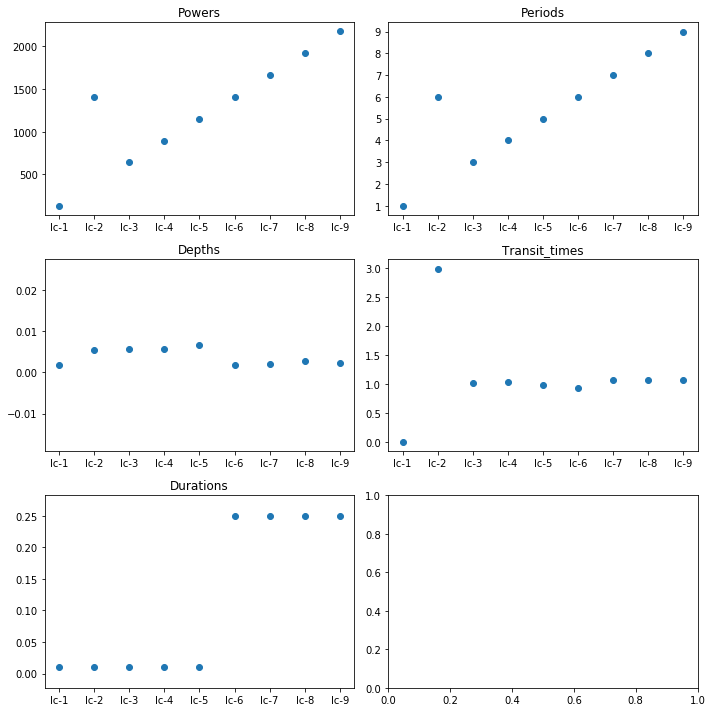

In [16]:
#plot simulated lc stats

f, (axes) = plt.subplots(3,2,figsize=(10,10))
axes[0,0].scatter(list(sim_stats.keys()),sim_powers)
axes[0,0].set_title('Powers')
axes[0,1].scatter(list(sim_stats.keys()),sim_periods)
axes[0,1].set_title('Periods')
axes[1,0].scatter(list(sim_stats.keys()),sim_depths)
axes[1,0].set_title('Depths')
axes[1,1].scatter(list(sim_stats.keys()),sim_tt)
axes[1,1].set_title('Transit_times')
axes[2,0].scatter(list(sim_stats.keys()),sim_durs)
axes[2,0].set_title('Durations');
plt.tight_layout()
print(changes);

# Testing ~ Kepler EBs ~

In [322]:
##open table of kics & periods

# keplers = pd.read_csv('data/KeplerEBs_file.csv',skiprows=3,header=4) #more columns
keplers2 = pd.read_csv('data/KeplerEBs_file-2',header=1) #min columns needed
shortkep = keplers2[(keplers2['period']>.5) &(keplers2['period']<15)] # only periods within TESS likely range
print('column names:',list(shortkep.columns))
print('all EBs:',len(keplers2),'; EBs within 0-15period range:',len(shortkep))

column names: ['KIC', 'period', 'period_err', 'Teff', 'Unnamed: 4']
all EBs: 2922 ; EBs within 0-15period range: 1661


power: 1 period: 0.5039007801560312 depth: 0.004652455242828815 duration: 0.49 transit-time: 0.268


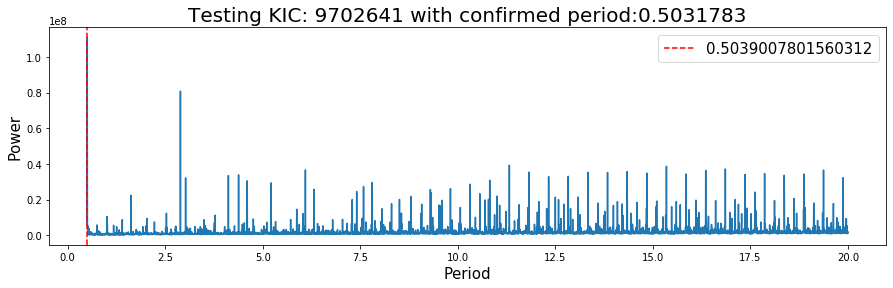

In [327]:
##get data & run bls on first kic in shortkep

# load data
test_klcfile = pd.read_csv('data/KeplerEBs/09702641.00.lc.data.tsv',header=0,delimiter ='	')
test_ktime = test_klcfile['# bjd']
test_kflux = test_klcfile['dtr_flux']
test_kfluxerr = test_klcfile['dtr_err']
# run bls
test_kic = shortkep['KIC'].iloc[0]
test_kicper = shortkep[shortkep['KIC'] ==shortkep['KIC'].iloc[0]]['period'].to_numpy()[0]
test_klc = lk.lightcurve.LightCurve(flux=test_kflux,time=test_ktime,flux_err=test_kfluxerr) #make lk object
test_kstats = run_bls(test_kic,test_klc)
print('power:',test_kstats['power'],'period:',test_kstats['period'],'depth:',test_kstats['depth'],'duration:',test_kstats['duration'],'transit-time:',test_kstats['transit_time'])
plt.figure(figsize=(15,4))
plt.plot(test_kstats['periodogram'].period,test_kstats['periodogram'].power)
plt.axvline(test_kstats['period'],ls='--',color='r',label=test_kstats['period'])
plt.legend(fontsize=15);plt.xlabel('Period',fontsize=15);plt.ylabel('Power',fontsize=15)
plt.title('Testing KIC: {} with confirmed period:{}'.format(test_kic,test_kicper),fontsize=20);

In [326]:
# # DO ~NOT~ RUN AGAIN --DATA ALREADY DOWNLOADED

# #dl data for all targets desired---every 3rd to get diverse sample (og table sorted by period lo-hi)

# import requests
# n = 3 #only dl every 3rd lc
# dl_count = 0
# for count,i in enumerate(list(shortkep['KIC'])):
#     if count % n == 0: #remainder ==0 after division by interval
#         kic = i
#         url = 'http://keplerebs.villanova.edu/data/?k={}.00&cadence=lc&data=data'.format(kic)
#         r = requests.get(url, allow_redirects=True)
#         filename = 'data/KeplerEBs/{}_lc.csv'.format(kic)
#         open(filename, 'wb').write(r.content)
#         dl_count +=1
#     else:
#         pass
# print('Total files downloaded (.5<per<15):',dl_count)
print('Total files downloaded (.5<per<15): 554'

Total files downloaded (.5<per<15): 554


In [379]:
#fcn to open kep eb data

def kepEBopen(kic,path='mypath'):
    '''
    ~Opens Kepler EB data files I downloaded to my computer~
    Args: kic       -(int or str) id for kepler target
          path      -(str) path to csv data file, default is mypath, 
                      change it with {} where kic goes, header/delimiter 
                      specified for opening with pd.read_csv
    Returns: lightkurve Light Curve data object
    '''
    if path == 'mypath':
        try:
            kep_lcfile = pd.read_csv('data/KeplerEBs/{}_lc.csv'.format(kic),header=0,delimiter ='	')
            ktime = kep_lcfile['# bjd']
            kflux = kep_lcfile['dtr_flux']
            kfluxerr = kep_lcfile['dtr_err']
            klc = lk.lightcurve.LightCurve(flux=kflux,time=ktime,flux_err=kfluxerr)#make lk object
        except Exception as e:
            klc = "Verify KIC - couldn't open data file with mypath"
    else:
        try:
            kep_lcfile = pd.read_csv(path)
            ktime = kep_lcfile['# bjd']
            kflux = kep_lcfile['dtr_flux']
            kfluxerr = kep_lcfile['dtr_err']
            klc = lk.lightcurve.LightCurve(flux=kflux,time=ktime,flux_err=kfluxerr) #make lk object
        except Exception as e:
            klc = "Verify file path - couldn't open data file"
    return klc

In [386]:
def test_kepEBopen():
    kic1 = 123; kic2 = 5376552
    path2 = 'no/correct/path'
    test1 = kepEBopen(kic1,path=path2)
    test2 = kepEBopen(kic2)
    test3 = kepEBopen(kic1)
    assert test1 == "Verify file path - couldn't open data file"
    assert str(type(test2)) == "<class 'lightkurve.lightcurve.LightCurve'>"
    assert test3 == "Verify KIC - couldn't open data file with mypath"
    

In [393]:
testlc = kepEBopen(5376552)
testlc.time,testlc.flux,testlc.flux_err
# test_kepEBopen()


(array([54953.53883914, 54953.55927372, 54953.5797082 , ...,
        56423.96023499, 56423.98066943, 56424.00110407]),
 array([0.855132, 0.775001, 0.738166, ..., 0.770989, 0.749795, 0.80077 ]),
 array([7.3e-05, 7.3e-05, 7.3e-05, ..., 7.0e-05, 6.9e-05, 7.1e-05]))

In [ ]:
# # tests for opening dl'ed kepler eb files
kep_table = pd.read_csv('data/KeplerEBs/KeplerEB_bls_stats.csv') #a subselection with <15 day periods
kics = kep_table['KIC'].to_numpy()
trueper = kep_table['period_truth'].to_numpy()
KEBids=[];KEBtrueper=[];KEBpowers=[];KEBperiods=[];KEBdepths=[];KEBdurs=[];KEBtts=[];KEBexpectedrp=[]

for count,kic in enumerate(kics):
    print('starting {} out of {}'.format(count,len(kics)))
    kep_lcfile = pd.read_csv('data/KeplerEBs/{}_lc.csv'.format(kic),header=0,delimiter ='	')
    ktime = kep_lcfile['# bjd']
    kflux = kep_lcfile['dtr_flux']
    kfluxerr = kep_lcfile['dtr_err']
    klc = lk.lightcurve.LightCurve(flux=kflux,time=ktime,flux_err=kfluxerr) #make lk object
    
    
    #     kstats = run_bls(kic,klc)
#     KEBids.append(kic);KEBtrueper.append(trueper[count])
#     KEBpowers.append(kstats['power']);KEBperiods.append(kstats['period']);KEBdepths.append(kstats['depth']);
#     KEBdurs.append(kstats['duration']);KEBtts.append(kstats['transit_time'])
# #make a table

# kep_table2 = Table([KEBids,KEBtrueper,KEBperiods,KEBpowers,KEBdepths,KEBdurs,KEBtts],
#                  names=('KIC','period_truth','period_bls','power_bls','depth_bls','dur_bls','tt_bls'))

# ascii.write(kep_table2, 'data/KeplerEBs/KeplerEB_bls_stats2.csv',format='csv', overwrite=True)  

In [336]:
# get bls stats for all EBs (.5<per<15)----takes long to run so reopen saved table at end of this cell

# KEBids=[];KEBpowers=[];KEBperiods=[];KEBdepths=[];KEBdurs=[];KEBtts=[];KEBexpectedrp=[]
# n = 3   #only every 3rd
# for count,i in enumerate(list(shortkep['KIC'])):
#     if count % n == 0: 
#         kic = i
#         kep_lcfile = pd.read_csv('data/KeplerEBs/{}_lc.csv'.format(kic),header=0,delimiter ='	')
#         ktime = kep_lcfile['# bjd']
#         kflux = kep_lcfile['dtr_flux']
#         kfluxerr = kep_lcfile['dtr_err']
#         krp = shortkep[shortkep['KIC'] ==i]['period'].to_numpy()[0]
#         # run bls
#         kicper = shortkep[shortkep['KIC'] ==i]['period'].to_numpy()[0]
#         KEBexpectedrp.append(kicper)
#         klc = lk.lightcurve.LightCurve(flux=kflux,time=ktime,flux_err=kfluxerr) #make lk object
#         kstats = run_bls(kic,klc)
#         KEBids.append(kic);KEBpowers.append(kstats['power']);KEBperiods.append(kstats['period']);KEBdepths.append(kstats['depth']);KEBdurs.append(kstats['duration']);KEBtts.append(kstats['transit_time'])
# #     elif count ==20:
# #         break
#     else:
#         pass
# #make a table

# kep_table = Table([KEBids,KEBexpectedrp,KEBperiods,KEBpowers,KEBdepths,KEBdurs,KEBtts],
#                  names=('KIC','period_truth','period_bls','power_bls','depth_bls','dur_bls','tt_bls'))

# #ascii.write(kep_table, 'data/KeplerEBs/KeplerEB_bls_stats.csv',format='csv', overwrite=True) #already ran
kep_table = pd.read_csv('data/KeplerEBs/KeplerEB_bls_stats.csv')
kep_table

,KIC,period_truth,period_bls,power_bls,depth_bls,dur_bls,tt_bls
0,9702641,0.503178,0.503901,1,0.004652,0.49,0.268
1,5376552,0.503819,2.267053,453,0.147272,0.01,0.578
2,9813678,0.505079,1.767754,325,0.020887,0.01,0.009
3,5128972,0.505324,2.021304,390,0.078197,0.01,1.039
4,5088735,0.507501,0.507802,2,0.001164,0.25,0.313
...,...,...,...,...,...,...,...
549,6286155,14.541830,14.542809,3600,0.001108,0.25,6.024
550,4252322,14.591516,14.593519,3613,0.000158,0.25,5.422
551,12470041,14.667742,1.248950,192,0.001953,0.49,0.431
552,10592163,14.762947,14.761252,3656,0.043586,0.25,2.341


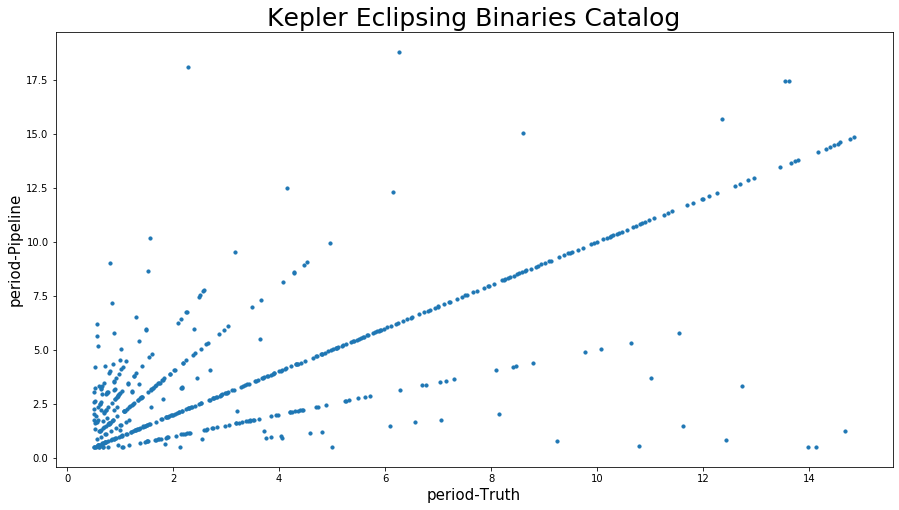

In [339]:
plt.figure(figsize=(15,8))
plt.scatter(kep_table['period_truth'],kep_table['period_bls'],s=10)
plt.title('Kepler Eclipsing Binaries Catalog',fontsize=25)
plt.xlabel('period-Truth',fontsize=15);plt.ylabel('period-Pipeline',fontsize=15);

# Opening BLS results

In [193]:
#open bls outputs 
firstdf = pd.read_csv('data/FOURTHRUN/BLS_stats_table.csv')
seconddf = pd.read_csv('data/FOURTHRUN/BLS_stats_table2.csv')
thirddf = pd.read_csv('data/FOURTHRUN/BLS_stats_table3.csv')

#merge into one df
final_df = pd.concat([firstdf, seconddf, thirddf ], axis=0,ignore_index=True)
#check final lenghts
print('df lenghts:',len(firstdf),len(seconddf),len(thirddf),'total:',len(firstdf)+len(seconddf)+len(thirddf),'final:',len(final_df))
# final_df

######REMEMBER TO REMOVE THOSE 0'ED OUT FIRST ROWS

df lenghts: 8599 224 15249 total: 24072 final: 24072


In [341]:
# list(final_df.columns)[1::] 
# plt.scatter(list(real_stats.keys()),arrs[0])
# plt.scatter(final_df['tic'],final_df['power'])
# plt.xticks(rotation=90);
# int(list(real_stats.keys())),
# final_df['tic'].values
mytest = [int(i) for i in real_stats.keys()]
len(mytest),len(arrs[0])

(32, 32)

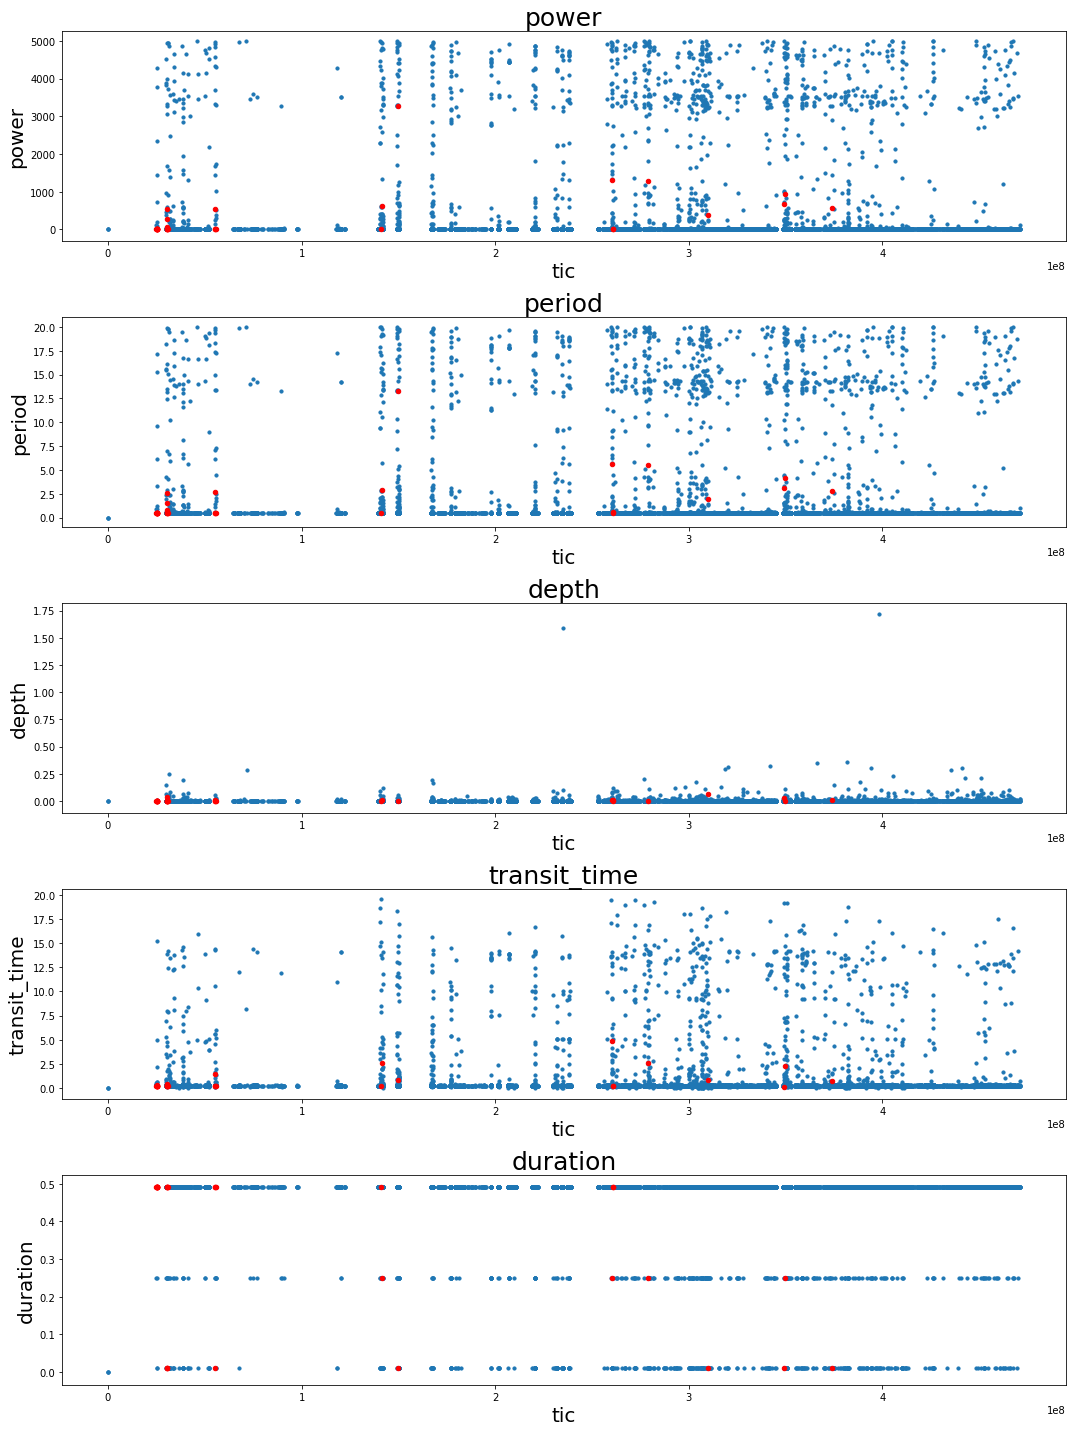

In [252]:
colnames = list(final_df.columns)[1::] 
f, ax = plt.subplots(len(colnames),1,figsize=(15,20))
for count,i in enumerate(colnames):
    x_param='tic'
    ax[count].scatter(final_df[x_param].values,final_df[i].values,s=10)
    ax[count].set_title('{}'.format(i),fontsize=25)
    ax[count].scatter([int(i) for i in real_stats.keys()],arrs[count],color='r',s=20)#verified arrs stats are same order as final_df colnames
    ax[count].set_ylabel('{}'.format(i),fontsize=20);
    ax[count].set_xlabel('{}'.format(x_param),fontsize=20);
plt.tight_layout()

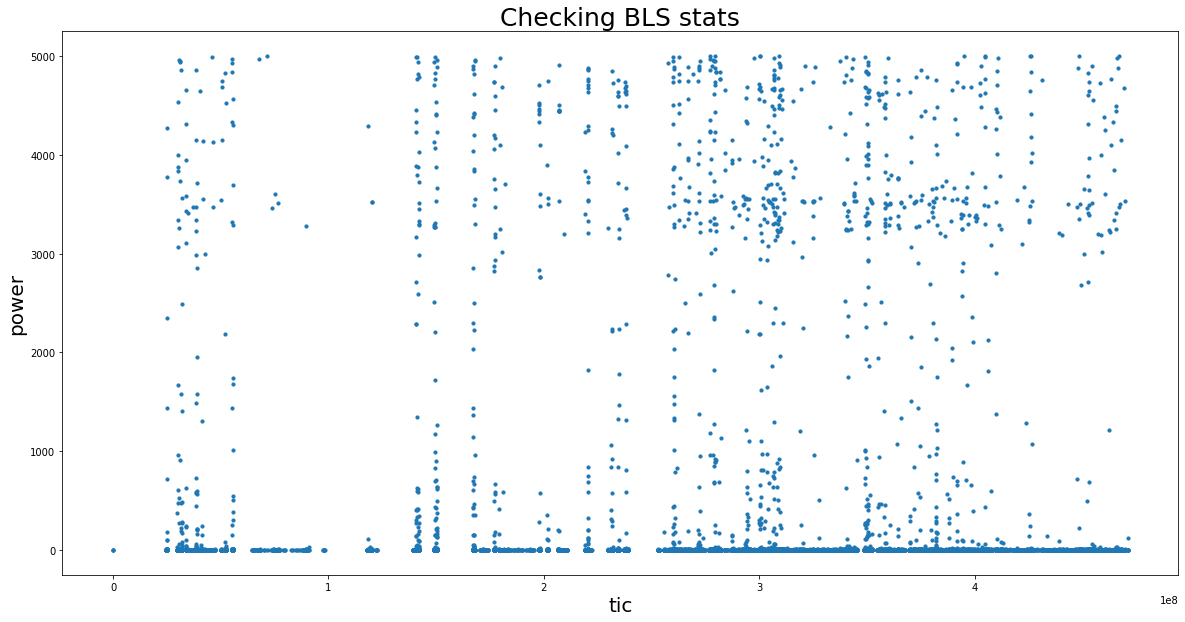

In [194]:
#plot stats

x_param = 'tic'
y_param = 'power'
plt.figure(figsize=(20,10))
plt.scatter(final_df[x_param],final_df[y_param],s=10)
plt.title('Checking BLS stats for REAL TESS lcs',fontsize=25)
plt.xlabel(x_param,fontsize=20)
plt.ylabel(y_param,fontsize=20);

TIC: 0 had no bls because [Errno 2] No such file or directory: 'data/FOURTHRUN/data_arrs/0/blsx_periods.npy'


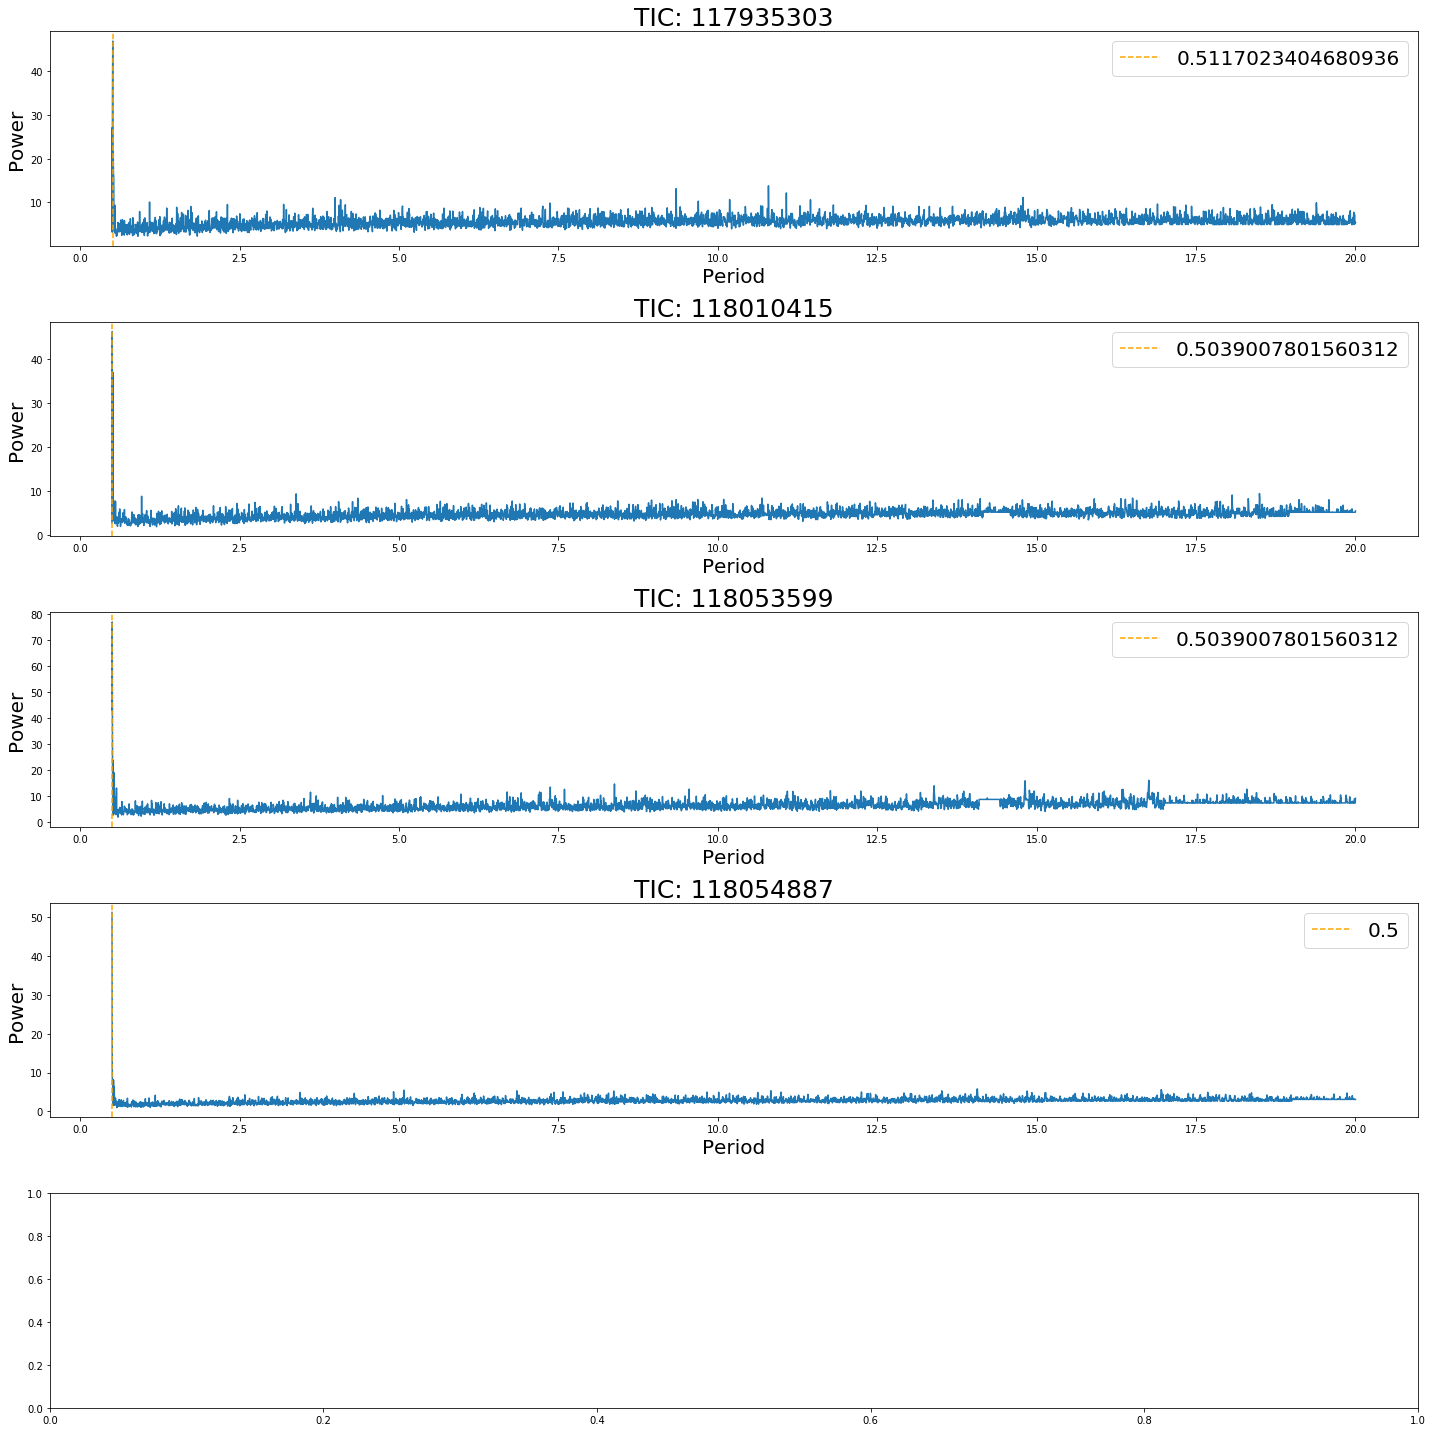

In [195]:
###check output periodograms

# tics = []
tics = final_df['tic'][0:5]

count=0
f,ax = plt.subplots(len(tics),1,figsize=(20,20))
for tic in tics:
    try:        
        xs = np.load('data/FOURTHRUN/data_arrs/{}/blsx_periods.npy'.format(tic))
        ys = np.load('data/FOURTHRUN/data_arrs/{}/blsy_powers.npy'.format(tic))
        tic_df = final_df[final_df['tic']==tic]
        ax[count].plot(xs,ys)
        ax[count].axvline(tic_df['period'].to_numpy()[0], ls='--',color='orange',label=tic_df['period'].to_numpy()[0])
        ax[count].legend(fontsize=20)
        ax[count].set_ylabel('Power',fontsize=20)
        ax[count].set_xlabel('Period',fontsize=20)
        ax[count].set_title('TIC: {}'.format(tic),fontsize=25)
        count+=1
    except Exception as e:
        print('TIC: {} had no bls because {}'.format(tic,e))
plt.tight_layout()

# ---------------------TESTS---------------------

### bls tutorial test

In [28]:
#tutorial using sim lcs

import astropy.units as u
np.random.seed(42)
t = np.random.uniform(0, 20, 2000)
y = np.ones_like(t) - 0.1*((t%3)<0.2) + 0.01*np.random.randn(len(t)) # t%3 ##Divides left hand operand by right hand operand and returns remainder
model = BoxLeastSquares(t * u.day, y, dy=0.01)
period_grid = np.linspace(.5,20,5000)#try making this log
###below middle input MUST be less than above first input###
duration_grid = np.linspace(.1,.49,1000)#maybe using this will allow periods to go lower than .5

#test in 2 diff ways
test_periodogram = model.power(period_grid, duration_grid) #0.16 was the duration grid
tutorial_periodogram = model.autopower(0.2)#.2 is the duration here aka transit width
# model.autopower??
# model.power??

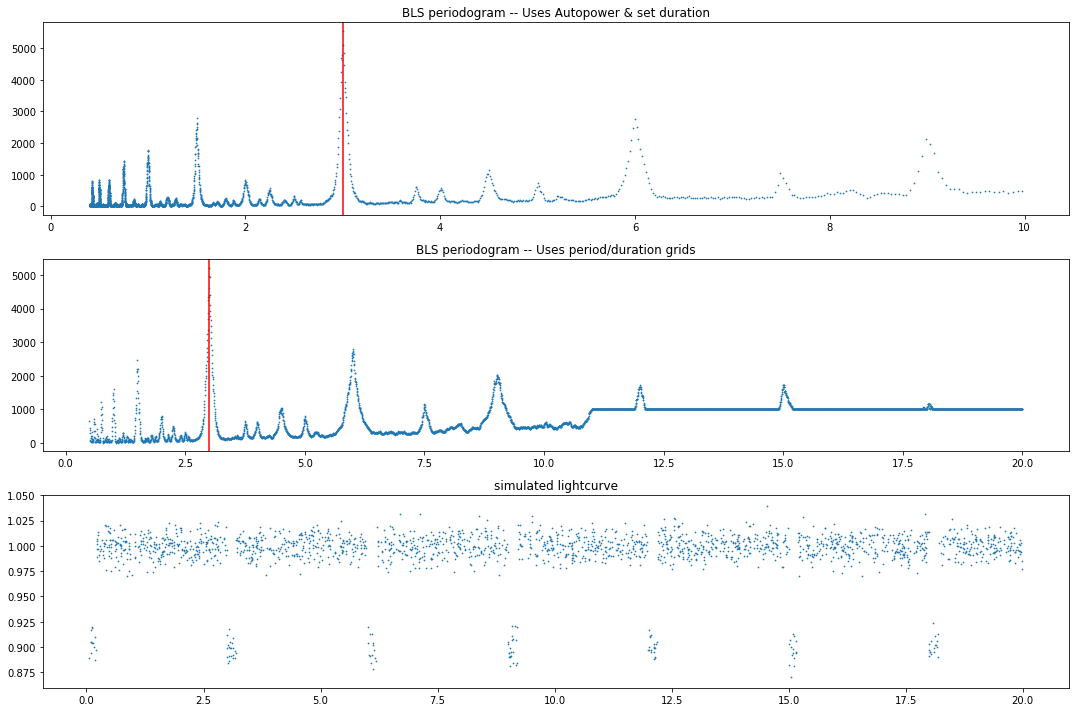

In [29]:
#check periodograms from 2 ways in tutorial

f,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(15,10))
# plt.scatter(periodogram['period'],periodogram['power'],s=.5) #works
ax1.scatter(tutorial_periodogram.period,tutorial_periodogram.power,s=.5) #also works
ax1.axvline(3,color='r')
ax1.set_title('BLS periodogram -- Uses Autopower & set duration')
ax2.scatter(test_periodogram.period,test_periodogram.power,s=.5) 
ax2.axvline(3,color='r')
ax2.set_title('BLS periodogram -- Uses period/duration grids')
ax3.scatter(t,y,s=.5)
ax3.set_title('simulated lightcurve');
plt.tight_layout()

### test bls on a real planet

In [31]:
# test bls on a real good planet --part 1

tic = 149603524 #good planet
# cleanlc,bads = prep_lcfs(tic,'mypath') #---SLOW
cleanlc = open_lc(tic,'mypath') #----FAST

clean = cleanlc.flatten()
# clean = clean.remove_outliers(sigma=7) #proved this is a bad thing to do
time = clean.time - clean.time[0]
flux = clean.flux
fluxerr = clean.flux_err

model_REAL = BoxLeastSquares(time, flux, dy=fluxerr)
period_grid = np.linspace(.5,20,5000)
duration_grid = np.linspace(.1,.49,10)
periodogram_testREAL = model_REAL.power(period_grid,duration_grid)

bls period is: 4.412482496499299
expected: ~ 4.41


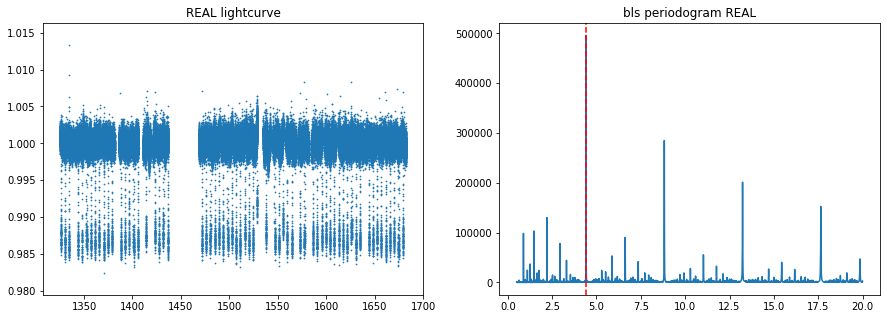

In [32]:
# test bls on a real good planet --part 2


f,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.scatter(cleanlc.time,cleanlc.flux,s=.5)
ax1.set_title('REAL lightcurve')
ax2.plot(periodogram_testREAL.period,periodogram_testREAL.power)
ax2.axvline(4.41,color='r',ls='--')#expected period
ax2.set_title('bls periodogram REAL');
print('bls period is:',periodogram_testREAL.period[np.argmax(periodogram_testREAL.power)])
print('expected: ~ 4.41')

### no noise in lc but testing diff noise inputs to bls


expected 4.0 and got 4.002900580116023


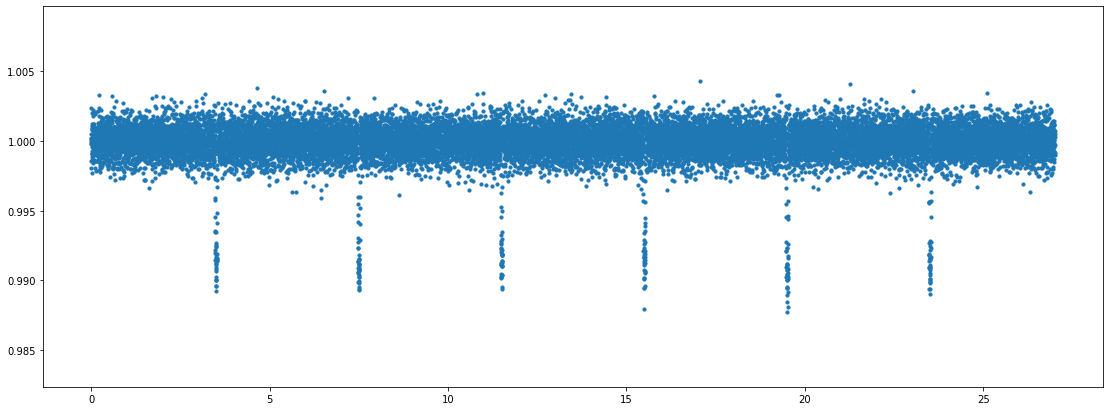

In [33]:
# fix period and depth and see how noise levels affect bls period
#forgot to fix depths 

import batman
params = batman.TransitParams()
t = np.linspace(0,27,19440)
params.per= 4.;params.rp=0.1;params.t0 = 3.5;params.a = 15.;params.inc=87.
params.ecc = 0.;params.w=90.;params.limb_dark ='nonlinear';params.u = [0.5, 0.1, 0.1, -0.1]
m = batman.TransitModel(params, t)    #initializes model
flux1 = m.light_curve(params)

period_grid = np.linspace(.5,20,5000)
# duration_grid = np.linspace(.01,.49,1000) #test
duration_grid = np.linspace(.01,.49,3) #worked on real planet


#before using bls should be flatten, removeoutliers, something else??
unc_level=.001
flux_wnoise = np.random.randn(len(flux1))*unc_level + flux1
noise = np.ones_like(flux1)*unc_level

# f_unc = np.repeat(unc_level,len(flux1))
# noise = np.random.normal(flux1-1,unc_level,len(flux1))
# cleanlc = lk.lightcurve.TessLightCurve(flux=flux1,time=t,flux_err=noise)
# print('tests;',len(noise),len(t),len(f_unc))
cleanlc = lk.lightcurve.TessLightCurve(flux=flux_wnoise,time=t,flux_err=noise)


clean = cleanlc.flatten()
# clean = clean.remove_outliers(sigma=7)
time = clean.time - clean.time[0]
flux = clean.flux
fluxerr = clean.flux_err

# ex-1
model = BoxLeastSquares(time, flux, dy=0.0001) #small
periodogram_test_small = model.power(period_grid,duration_grid)
# ex-2
model2 = BoxLeastSquares(time, flux, dy=0.01) #large
periodogram_test_large = model2.power(period_grid,duration_grid)
# ex-3
# test_noise = np.random.normal(flux-1,.001,len(flux))#mean,std,numpts ## 1% noise level; 
model3 = BoxLeastSquares(time, flux, dy=fluxerr) #norm
periodogram_test_norm = model3.power(period_grid,duration_grid)
# ex-4
model4 = BoxLeastSquares(time,flux+fluxerr,dy=fluxerr)
periodogram_test_fwerr = model4.power(period_grid,duration_grid)


print('expected {} and got {}'.format(params.per,periodogram_test_norm.period[np.argmax(periodogram_test_norm.power)]))
#plot sim_lc WITH noise
plt.figure(figsize=(19,7))
# plt.scatter(time,flux1+noise,s=.5,color='r')
plt.scatter(time,flux,s=10) #sim with extra cleaning
# plt.scatter(t+1,flux1,s=.2,color='green')#og sim

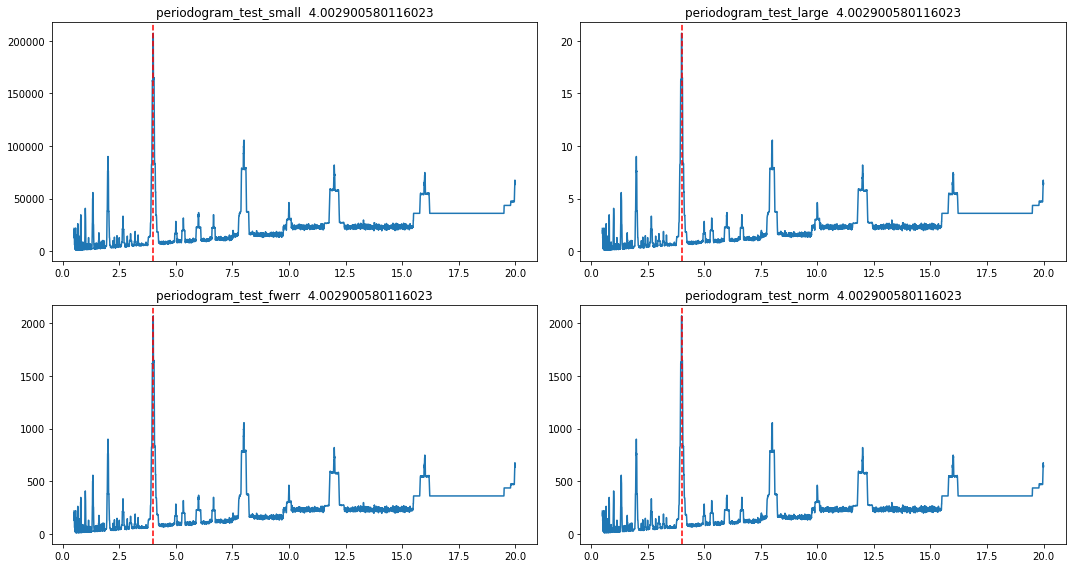

In [35]:
## plot periodograms of different noise level tests

f,(ax) = plt.subplots(2,2,figsize=(15,8))
ax[1,0].plot(periodogram_test_fwerr.period,periodogram_test_fwerr.power)
ax[1,0].axvline(4,color='r',ls='--')
ax[1,0].set_title('periodogram_test_fwerr  {}'.format(periodogram_test_fwerr.period[np.argmax(periodogram_test_fwerr.power)]))
ax[0,0].plot(periodogram_test_small.period,periodogram_test_small.power)
ax[0,0].set_title('periodogram_test_small  {}'.format(periodogram_test_small.period[np.argmax(periodogram_test_small.power)]))
ax[0,0].axvline(4,color='r',ls='--')
ax[0,1].plot(periodogram_test_large.period,periodogram_test_large.power)
ax[0,1].axvline(4,color='r',ls='--')
ax[0,1].set_title('periodogram_test_large  {}'.format(periodogram_test_large.period[np.argmax(periodogram_test_large.power)]))
ax[1,1].plot(periodogram_test_norm.period,periodogram_test_norm.power)
ax[1,1].axvline(4,color='r',ls='--')
ax[1,1].set_title('periodogram_test_norm  {}'.format(periodogram_test_norm.period[np.argmax(periodogram_test_norm.power)]));
plt.tight_layout();

# wow these Powers are radically different
#small: 0.0001; large: 0.01; noise: normaldistrw/std=0.01

### now adding noise to lc & bls input

In [36]:
# test_noise2 = np.random.normal(flux-1,.01,len(flux))#mean,std,numpts ## 1% noise level; -1 so that flux stays around 1
# newflux = flux + test_noise2

# f,(ax1,ax2) = plt.subplots(1,2,figsize=(15,4))
# ax1.scatter(t,newflux,s=.2)
# ax2.set_title('full lc with added noise')
# ax1.set_xlim(3,4) #checking transit clarity
# ax2.scatter(t,newflux,s=.2)
# ax1.set_title('verifying transit still visible');

In [37]:
# model4 = BoxLeastSquares(t, newflux, dy=test_noise2) #norm noise
# periodogram_test_noise = model4.power(period_grid,duration_grid)

# plt.plot(periodogram_test_noise.period,periodogram_test_noise.power)
# plt.axvline(4,color='r',ls='--')
# plt.title('BLS Periodogram -- full normal noise in bls')
# print('expected period {} and got:'.format(params.per),periodogram_test_noise.period[np.argmax(periodogram_test_noise.power)])
# # changed noise (flux-1) and now super weird BUT still got extremely close to correct rp==4


In [38]:
# ## changed noise in BLS so noise is left in lc


# model5 = BoxLeastSquares(t, newflux, dy=test_noise2/2) #left some noise in lc this time
# periodogram_test_leftinnoise = model5.power(period_grid,duration_grid)

# plt.plot(periodogram_test_leftinnoise.period,periodogram_test_leftinnoise.power)
# plt.axvline(4,color='r',ls='--')
# plt.title('BLS Periodogram --Left noise in the sim lc (used 1/2 noise for bls) ');
# print('expected period {} and got:'.format(params.per),periodogram_test_leftinnoise.period[np.argmax(periodogram_test_leftinnoise.power)])


# # so noise in the lc boosted the power...??--n/m changed the noise since this run

In [39]:
# f,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
# ax1.hist(test_noise2);
# ax1.set_title('confirming a normal dist of noise (with the flux-1)');
# ax2.hist(newflux);
# ax2.set_title('newflux with added noise');

In [46]:
# ##test full run_bls_FINAL.py

# from astropy.table import Table
# from astropy.timeseries import BoxLeastSquares
# import lightkurve as lk
# from astropy.io import ascii
# from astropy.io import fits
# import numpy as np

# ########functions##########

# def open_lc(tic,path):
#     '''
#     Opens lightkurvefile object as a lightkurve file...
#     ...a work around b/c cleaned_lcs saved as lkfiles lose the flux attribute
    
#     Requirements: astropy.io.fits; lightkurve;
#     inputs:   tic (int or str)
#               path (str); '"mypath" is for me only, all others must specify filepath'
#     outputs:  lightkurve lightcurve object
#               additional output - writes text file of tics unable to open & exceptions (this path is hardcoded so only works for me)
#     '''
#     try:
#         if path == 'mypath':
#             filepath = 'data/SECONDRUN/cleaned_LightCurves/{}/lc.fits'.format(tic)
#         else:
#             filepath = path
#         openfile = fits.open(filepath)
#         filedata = openfile[1].data
#         lc = lk.lightcurve.TessLightCurve(flux=filedata['FLUX'],time=filedata['TIME'],flux_err=filedata['FLUX_ERR'])
#     except Exception as e:
#         lc = 'None for TIC: {}'.format(tic)
#         print('TIC: {} failed to open as lk lc'.format(tic))
#         stmt = 'TIC: {} had error {}\n'.format(tic,e)
# #         with open("data/FOURTHRUN/BLS_couldnt_openfile.txt","a") as text_file:
# #             text_file.write("\n")
# #             text_file.write(stmt)
#     return lc


# def bls_stats(tic,lc):
#     '''
#     Runs BoxLeastSquares(BLS) on a light curve and returns BLS statistics.
    
#     REQUIRES: numpy, astropy.timeseries.BoxLeastSquares,
#     Args:   tic id      -(int or str)
#             lc          -(lightkurve light curve object)
#             plot        -(boolean) optional, if True plots 
#                           periodogram and phase folded light curve 
#                           and binned phase folded light curve
                    
#     outputs: bls_stats  -(dictionary) Box Least Squares statistics 
#                           of 'power', 'period', 'depth', 'duration', 'transit_time' 
#     '''
#     assert(str(type(lc)) == "<class 'lightkurve.lightcurve.TessLightCurve'>");
#     ###gets cleaned data
#     clean = lc.flatten()
#     time = clean.time - clean.time[0]
#     flux = clean.flux
#     fluxerr = clean.flux_err
#     ###gets periodogram based on bls
#     from astropy.timeseries import BoxLeastSquares
#     model = BoxLeastSquares(time, flux, dy=fluxerr)
#     period_grid = np.linspace(.5,20,5000)
#     duration_grid = np.linspace(.01,.49,3)
#     periodogram = model.power(period_grid, duration_grid) 
#     ppower = np.argmax(periodogram.power)
#     pperiod = periodogram.period[np.argmax(periodogram.power)]
#     depth = periodogram.depth[np.argmax(periodogram.power)]
#     duration = periodogram.duration[np.argmax(periodogram.power)]
#     tt = periodogram.transit_time[np.argmax(periodogram.power)]
#     ###writes data to files
#     bls_y = periodogram.power
#     bls_x = periodogram.period
#     #######This part missing try/except added later##########
# #     np.save('data/FOURTHRUN/data_arrs/{}/blsx_periods'.format(tic),bls_x)
# #     np.save('data/FOURTHRUN/data_arrs/{}/blsy_powers'.format(tic),bls_y)
    
#     return tic, ppower, pperiod, depth, tt, duration 




# ##########start on targets##########

# # tics = np.load('data/all_dled_tics.npy')
# # tics = [149603524, 9999999, 25063396, 149603524, 9999999]
# tics = [294274455,9999999]


# t = Table()
# t['tic'] = [0]; t['power'] = [0.]; t['period']=[0.];t['depth']=[0.];t['transit_time']=[0.];t['duration']=[0.]
# for count,tic in enumerate(tics):
#     print('Starting on TIC: {} ....................which is {} of {}'.format(tic, count,len(tics)))
#     lc = open_lc(tic,'mypath')
#     if str(type(lc)) == "<class 'lightkurve.lightcurve.TessLightCurve'>":
#         print('Starting BLS')
#         stats = bls_stats(tic,lc)
#         t.add_row((stats[0],stats[1],stats[2],stats[3],stats[4],stats[5]))
# #         ascii.write(t, 'data/FOURTHRUN/BLS_stats_table.csv',format='csv', overwrite=True)
#         print('Finished BLS stats:')
#     else:
#         pass

Starting on TIC: 294274455 ....................which is 0 of 2
Starting BLS
Xs: [ 0.5         0.50390078  0.50780156 ... 19.99219844 19.99609922
 20.        ] Ys: [ 2.92540306 11.38573283  1.62236576 ...  2.64256812  2.91402423
  3.470818  ]
Finished BLS stats:
Starting on TIC: 9999999 ....................which is 1 of 2
TIC: 9999999 failed to open as lk lc


### making code modular

In [ ]:
#key steps in bls

# -flatten lc & zero out the time for folding
# -define period & duration grids
# -define the bls model & pull stats
-phase fold at period
#plots needed for verification
-phase folded
-bin folded
-periodogram
# -original lc

In [333]:
# open only sector1 lcs
from astropy.io import fits
from astropy.timeseries import BoxLeastSquares

def fake_data(N=1000,unc=1e-3,time_start=0,time_end=25):
    '''
    ~Generate fake data for a lightcurve~
    Requires: numpy;
    Args:       N           -(int)number of desired data points
                unc         -(int|float or array)level of uncertainity for flux
                time_start  -(int)starting time
                time_end    -(int)stopping time
    Returns:    time,flux,flux_err arrays
    '''
    sample_size = N
    time = np.linspace(time_start,time_end,sample_size)
    unc = unc
    flux = np.random.randn(len(time))*unc + 1
    flux_err = np.ones_like(flux)*unc
    
    return time,flux,flux_err
def test_fake_data():
    test1 = fake_data(10,.1,0,20)
    test2 = fake_data()
    assert(len(test1[0])==len(test1[1])==len(test1[2]))
    assert(len(test2[0])==len(test2[1])==len(test2[2]))
##########################################################################
def open_mylcs(tic,sector):
    '''
    ~Opens previously cleaned light curve file~
    Requires:       astropy.io.fits;
    Args:           tic         -(int) TESS TIC ID
                    sector      -(int) light curve sector number for target
    Returns:        time, flux, flux_err (numpy arrays) 
    '''
    filepath = 'data/SECONDRUN/cleaned_LightCurves/{}/sector{}_lc.fits'.format(tic,sector)
    try:
        lc = fits.open(filepath)
        lc_data = lc[1].data
        time=lc_data.TIME; flux=lc_data.FLUX; flux_err=lc_data.FLUX_ERR
    except Exception as e:
        print('TIC: {} Sector: {} couldnt be opened; encountered Error: {}'.format(tic,sector,e))
    
    return time,flux,flux_err

def test_open_mylcs(tic,sector):
#     if (type(tic) == int) |(type(tic)==str) and (type(sector) == int) |(type(sector)==str): #cant use strings b/c fails will pass test
    if type(tic) == int and type(sector)==int:
        score = 'test_open_mylcs: passed'
    else:
        score = 'test_open_mylcs: FAILED'
    return score
##########################################################################

def plot_lc(time,flux,flux_err='None',ID = 'Light Curve'):#,xlim=(int(time[0])-1,int(time[-1])+1),ylim=(min(flux)-.5,max(flux)+.5)):
    '''
    ~Plots light curve~
    Requires:        matplotlib.pyplot; 
    Args:            time         -(np.array)
                     flux         -(np.array) 
                     flux_err     -Optional(np.array)-default is none
                     ID           -Optional(str or int) target id number for plot title;
    Returns:         Nothing, it just automatically plots the light curve
                     
    '''
    plt.figure(figsize=(20,10))
    plt.scatter(time,flux,s=2,color='k')
    plt.xlabel('Time',fontsize=25)
    plt.ylabel('Flux',fontsize=25)
    plt.xticks(fontsize=20);plt.yticks(fontsize=20)
    plt.title('{}'.format(ID),fontsize=30)
    if flux_err != 'None':
        plt.errorbar(time,flux,yerr=flux_err,color='lightgray')
    else:
        pass
    ###forget changing lims for now - not worth the time
#     if xlim != (int(time[0])-1,int(time[-1])+1) | ylim != (min(flux)-.5,max(flux)+.5):
#         plt.xlim(xlim[0],xlim[1])
#         plt.ylim(ylim[0],ylim[1])
#     else:
#         pass

def test_plot_lc():
    #generate fake data
    sample_size = 1000
    time = np.linspace(0,25,sample_size)
    unc = 1e-3
    flux = np.random.randn(len(time))*unc + 1
    flux_err = np.ones_like(flux)*unc
    ID2 = '2nd Light Curve';ID3 = 3,'rd Light Curve';
    ID4 = 'one constant error';fluxerr2 = 2
    
    plot_lc(time,flux)#1st plot-defaults
    plot_lc(time,flux,flux_err,ID2)#2nd plot
    plot_lc(time,flux,ID=ID3)#3rd plot
    plot_lc(time,flux,ID=ID4,flux_err=fluxerr2)#4th plot
    print('Expecting 4 plots with various differences')
    
#####old version before understood unit test 
# def test_plot_lc(time,flux,flux_err='None',ID ='Light Curve'):
#     if len(time) == len(flux):
#         if type(ID) == str:
#             if flux_err != 'None' and len(flux_err) == len(flux):
#                 score = 'test_plot_lc: passed'
#             elif flux_err == 'None':
#                 score = 'test_plot_lc: passed'
#             else:
#                 score = 'test_plot_lc: FAILED1'
#         else:
#             score = 'test_plot_lc: FAILED2'
#     else:
#         score = 'test_plot_lc: FAILED3'
#     return score

##########################################################################

def flatten_lc(time,flux,flux_err):
    '''
    ~Puts time,flux,fluxerr into a LightKurve Object to flatten - lk uses a wrapper
    on scipy.signal.savgol_filter.~
    
    Requires:            LightKurve;
    Args:                time      -(np.array)
                         flux      -(np.array)
                         flux_err  -(np.array)
    Returns:             Flattened time/flux/fluxerr arrays
    '''
    assert(len(time)==len(flux)==len(flux_err))#check same lenght
    lc = lk.lightcurve.LightCurve(flux=flux,time=time,flux_err=flux_err)#take generic lc
    flat_lc = lc.flatten()
    flat_time = flat_lc.time - flat_lc.time[0]
    flat_flux = flat_lc.flux
    flat_flux_err = flat_lc.flux_err
    
    return flat_time, flat_flux, flat_flux_err

def test_flatten_lc():
    #generate fake data
    sample_size = 1000
    time = np.linspace(0,25,sample_size)
    unc = 1e-3
    flux = np.random.randn(len(time))*unc + 1
    flux_err = np.ones_like(flux)*unc
    #run fcn test
    one,two,three = flatten_lc(time,flux,flux_err)
    assert(len(one)==len(two)==len(three)) #checks all arrays same length
    assert(one[0]==0.) #checks time
##########################################################################

def period_grid(start=0.5,stop=20,N=5000):
    '''
    ~generates list of periods for BLS to check~
    Requires: Numpy;
    Args:          start    -(int)lowest period to check;
                   stop     -(int)highest period to check;
                   N        -(int)number of periods between interval
                            Default values optimized for single TESS sector
    Returns:       array of periods to check
    '''
    p_grid = np.linspace(start,stop,N)
    return p_grid

def test_period_grid():
    start1=20;stop1=.5;N1=10;start2=1;stop2=10;N2=1
    test1 = period_grid(start1,stop1,N1)
    test2 = period_grid(start2,stop2,N2)
    test3 = period_grid()
    assert(test1[0]>test1[-1])
    assert(len(test2)==1)
    assert(len(test3)==5000)
    assert(test3[0]<test3[-1])
    
##########################################################################

def duration_grid(start=.01,stop=0.49,N=3):
    '''
    ~generates list of durations for BLS to check~
    Requires: Numpy;
    Args:          start  -(int)lowest period to check;
                   stop   -(int)highest period to check;
                   N      -(int)number of periods between interval
                          Default values optimized for single TESS sector
    Returns:       array of durations to check
    '''
    dur_grid = np.linspace(start,stop,N)
    return dur_grid

def test_duration_grid():
    start1=20;stop1=.5;N1=10;start2=1;stop2=10;N2=1
    test1 = duration_grid(start1,stop1,N1)
    test2 = duration_grid(start2,stop2,N2)
    test3 = duration_grid()
    assert(test1[0]>test1[-1])
    assert(len(test2)==1)
    assert(len(test3)==5000)
    assert(test3[0]<test3[-1])

##########################################################################

def bls(period_grid,duration_grid,time,flux,flux_err=0.):
    '''
    ~Runs Box Least Squares (BLS) on lightcurve data~
    Requires:        astropy.timeseries.BoxLeastSquares;
    Args:          period_grid     -(array) periods to check
                   duration_grid   -(array) durations to check
                   time            -(array) lightcurve times
                   flux            -(array) lightcurve flux
                   flux_err        -Optional(array or int) lightcurve flux error
    Returns:       BLS stats (periodogram, [power, period, depth, transit_time, duration])
    '''
    assert(len(time)==len(flux))
    assert(max(duration_grid)<min(period_grid))
    model = BoxLeastSquares(time, flux, dy=flux_err)
    periodogram = model.power(period_grid, duration_grid) 
    ppower = np.argmax(periodogram.power)
    pperiod = periodogram.period[np.argmax(periodogram.power)]
    pdepth = periodogram.depth[np.argmax(periodogram.power)]
    pduration = periodogram.duration[np.argmax(periodogram.power)]
    ptransittime = periodogram.transit_time[np.argmax(periodogram.power)]
    
    return periodogram, [ppower, pperiod, pdepth, pduration, ptransittime]

def test_bls():
    #generate fake data
    sample_size = 1000
    time = np.linspace(0,25,sample_size)
    unc = 1e-3
    flux = np.random.randn(len(time))*unc + 1
    flux_err = np.ones_like(flux)*unc
    #generate grids
    periodgrid1=period_grid();periodgrid2=period_grid(5,10,100)
    dur_grid1=duration_grid();dur_grid2=duration_grid(1,7,4)
    periodgrid3=period_grid(1.,10,100);dur_grid3=duration_grid(.001,.99,3)
    #run bls test
    test1 = bls(periodgrid1,dur_grid1,time,flux,flux_err) #defaults
    test2 = bls(periodgrid2,dur_grid2,time,flux,flux_err)# failure b/c pgrid<dgrid
    test3 = bls(periodgrid3,dur_grid3,time,flux,flux_err) # success
    print('one:',test1,'two:',test2,'three:',test3)
    assert(len(test1)==2)
    assert(test2=='assertionError')
    assert(len(test3)==2)

In [334]:
# t,f,fe = open_mylcs(149603524,1)
# plot_lc(t,f)
# test_plot_lc(t,f,ID='6776')
# print(len(t),len(f),len(fe))
# assert(len(t)==len(f)==len(fe))
#     lc = lk.lightcurve.LightCurve(flux=flux,time=
# ft,ff,ffe = flatten_lc(t,f,fe)
test_bls()

AssertionError: 

In [192]:
test_period_grid()

10 1 5000


In [ ]:


def run_bls(tic,lc,plot=False):
	'''
	Runs BoxLeastSquares(BLS) on a light curve and returns BLS statistics.
    
	REQUIRES: numpy, astropy.timeseries.BoxLeastSquares,
	Args:   tic id      -(int or str)
            lc          -(lightkurve light curve object)
            plot        -(boolean) optional, if True plots 
                          periodogram and phase folded light curve 
                          and binned phase folded light curve
                    
	outputs: bls_stats  -(dictionary) Box Least Squares statistics 
                          of 'power', 'period', 'depth', 'duration', 'transit_time' 
    '''
	assert(str(type(lc)) == "<class 'lightkurve.lightcurve.TessLightCurve'>");
	###gets cleaned data
	clean = lc.flatten()
# 	clean = clean.remove_outliers(sigma=7)
	time = clean.time - clean.time[0]
	flux = clean.flux
	fluxerr = clean.flux_err
	###gets periodogram based on bls
	from astropy.timeseries import BoxLeastSquares
	model = BoxLeastSquares(time, flux, dy=fluxerr) #dy=0.01)
	period_grid = np.linspace(.5,20,5000)#np.linspace(.1, 20, 50000) #1.0, 20, 50000should this stay the same?
# 	period_grid = np.logspace(.5,20,5000) #logspace causes some internal bls error
	duration_grid = np.linspace(.01,.49,3)#1000)#(.01,.49,1000)
	periodogram = model.power(period_grid, duration_grid) 
	ppower = np.argmax(periodogram.power)
	pperiod = periodogram.period[np.argmax(periodogram.power)]
	depth = periodogram.depth[np.argmax(periodogram.power)]
	duration = periodogram.duration[np.argmax(periodogram.power)]
	tt = periodogram.transit_time[np.argmax(periodogram.power)]
	bls_stats={}
	bls_stats['power']=ppower
	bls_stats['period']=pperiod
	bls_stats['depth']=depth
	bls_stats['duration']=duration
	bls_stats['transit_time']=tt
	bls_stats['periodogram']=periodogram
	###do some phase folding
	fold = clean.fold(period=periodogram.period[np.argmax(periodogram.power)])
	binfold = fold.bin(binsize=50)
	if plot == True:
		plt.clf()
		plt.plot(fold.time,fold.flux, '.',label = 'folded data')
		plt.plot(binfold.time,binfold.flux, 'r',lw=2, label = 'binned fold')
		plt.xlabel('Phase',fontsize=20)
		plt.ylabel('Relative Flux',fontsize=20)
		plt.title('All Sectors for TIC: {}'.format(tic),fontsize=20)
		fig=plt.gcf()
		fig.set_size_inches(20,14)
		plt.close()
		plt.clf()
		plt.plot(periodogram.period, periodogram.power) 
		plt.title('Periodogram for TIC: {}'.format(tic),fontsize=20)
		plt.xlabel('period',fontsize=20)
		plt.ylabel('power',fontsize=20)
		fig=plt.gcf()#gets current figure or creates one if none
		fig.set_size_inches(20,14)
		plt.show() 
	else:
		pass
    
	return bls_stats #power, period, depth, transit_time, duration,periodogram

